# Coursework 2 - Part 1

**Replace CID in the file name with your CID**

# Outline


- [Task 1](#task-1): Classification with a Convolutional Neural Network <a name="index-task-1"></a>
  - [(1.1)](#task-11) <a name="index-task-11"></a>
  - [(1.2)](#task-12) <a name="index-task-12"></a>
  - [(1.3)](#task-13) <a name="index-task-13"></a>
- [Task 2](#task-2): Dimensionality Reduction: PCA vs ISOMAP <a name="index-task-2"></a>
  - [(2.1)](#task-21)
  - [(2.2)](#task-22)
  - [(2.3)](#task-23)  



---



In [1]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import linalg
import pandas as pd
import torch
import random
from tabulate import tabulate

# Importing losses, activation functions and layers from PyTorch 
from torch.nn import Sequential, CrossEntropyLoss, Conv2d, MaxPool2d, Flatten, Linear, ReLU, Softmax, Parameter
from torch.utils.data import TensorDataset, DataLoader

In [2]:
# ensure plots are high quality
plt.rcParams['figure.figsize'] = [8.0, 8.0]
plt.rcParams['figure.dpi'] = 140

<a name="task-1"></a>

# (1) Task 1: Classification with a Convolutional Neural Network [(index)](#index-task-1)

<a name="task-11"></a>

## (1.1) [(index)](#index-task-11)

In [3]:
# import datasets

images_train = np.load('star_images_train.npy')
images_test = np.load('star_images_test.npy')

classes_train = np.load('star_classes_train.npy')
classes_test = np.load('star_classes_test.npy')

embeddings_train = np.load('star_embeddings_train.npy')

The input data consists of 32 features over 32 time steps. There are 648 examples in the training set and 32 in the test set. Note that the sample size of the test is very small in comparison to the training set.

In [4]:
classes = ['05V', 'A0V', 'F5V', 'M5V']

In [5]:
# set seed for reproducibility
np.random.seed(0)

# define indices for the split
indices = np.arange(len(images_train))
train_indices = np.random.choice(indices, size=int(0.75*len(indices)), replace=False)
val_indices = np.setdiff1d(indices, train_indices, assume_unique=True)

# split the datasets
images_train_split = images_train[train_indices]
classes_train_split = classes_train[train_indices]
embeddings_train_split = embeddings_train[train_indices]

images_val_split = images_train[val_indices]
classes_val_split = classes_train[val_indices]
embeddings_val_split = embeddings_train[val_indices]

In [6]:
def get_model(x_train, n_filters1, n_filters2, k1, k2, pool_size, stride_pool, classes, l2_reg=1e-3):
    """
    CNN model in PyTorch:
    - Layers are Conv2d(+ReLU), MaxPool2d, Conv2d(+ReLU), Flatten and Linear(+Softmax).
    - It features an Adam optimizer and CrossEntropyLoss criterion.
    - Conv2d and Linear layers have regularized weights according to l2_reg.

    Parameters:
    x_train: Training data
    n_filters1: Number of filters to be used in the first convolutional layer
    n_filters2: Number of filters to be used in the second convolutional layer
    k: Tuple specifying the kernel size in the convolutional layers, e.g., (5, 5)
    pool_size: Tuple specifying the MaxPool2d window size, e.g., (2, 2)
    stride_pool: Stride of the MaxPool2d sliding window
    classes: List containing the output classes
    l2_reg: Positive float corresponding to the regularization coefficient of Conv2d and Linear

    Returns:
    Model, criterion, and optimizer.
    """

    l_out_conv1 = np.array(x_train.shape[2:]) - np.array(k1) + 1 
    l_out_pool = (l_out_conv1 - np.array(pool_size)) // stride_pool + 1  
    l_out_conv2 = l_out_pool - np.array(k2) + 1 
    l_in_linear = n_filters2 * l_out_conv2[0] * l_out_conv2[1]  

    model = Sequential(
        Conv2d(1, n_filters1, k1),
        ReLU(),
        MaxPool2d(pool_size, stride=stride_pool),
        Conv2d(n_filters1, n_filters2, k2),
        ReLU(),
        Flatten(),
        Linear(l_in_linear, len(classes)),
        Softmax(dim=1),
    )

    criterion = CrossEntropyLoss()
    optimiser = torch.optim.Adam(model.parameters())

    return model, criterion, optimiser

In [7]:
# set seed for reproducability
torch.manual_seed(48)

# set variables required in question
n_filters1 = 4
n_filters2 = 8
k1 = 5
k2 = 5
pool_size = (2,2)
stride_pool = 2

# obtain model
model, criterion, optimiser = get_model(images_train_split, n_filters1, n_filters2, k1, k2, pool_size, stride_pool, classes) 

In [8]:
# Numpy arrays to PyTorch tensors
x_train_tensor = torch.tensor(images_train_split, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(classes_train_split)
x_val_tensor = torch.tensor(images_val_split, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(classes_val_split)

# Creating training and validation datasets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor.squeeze())
val_dataset = TensorDataset(x_val_tensor, y_val_tensor.squeeze())

# Creating corresponding DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

In [9]:
class EarlyStopping:
    """
    EarlyStopping class.

    Attributes:
    max_patience: Amount of epochs with no improvement after which training is stopped.
    patience: Stores the number of epochs with no improvement.
    best_valid_loss: Stores the current value of the best (minimum) validation loss.
    early_stop: True if training needs to be stopped due to the early stopping condition being met.

    Methods:
    step(val_loss):
        Checks current state after an epoch and updates best_loss, patience and early_stop accordingly.
    """

    def __init__(self, max_patience=5):
        self.max_patience = max_patience
        self.patience = 0
        self.best_valid_loss = float('inf') 
        self.early_stop = False

    def step(self, val_loss):
        if val_loss < self.best_valid_loss:  
            self.best_valid_loss = val_loss  
            self.patience = 0  
        else:
            self.patience += 1
            if self.patience >= self.max_patience:
                self.early_stop = True

In [10]:
def training_loop(train_loader, val_loader, max_num_epochs=2000, max_patience=150):
    """
    Training loop with early stopping to monitor the validation accuracy.

    Parameters:
    train_loader: Training DataLoader
    val_loader: Validation DataLoader
    max_num_epochs: Maximum number of epochs
    max_patience: max_patience attribute of the EarlyStopping class

    Returns:
    Model, criterion and optimiser.

    """

    history = {'training_loss': [], 'validation_loss': [], 'training_accuracy': [], 'validation_accuracy': []}
    early_stopping = EarlyStopping(max_patience=max_patience)

    for epoch in range(max_num_epochs):

        tr_loss = 0.0
        tr_accuracy = 0
        val_loss = 0.0
        val_accuracy = 0

        # Training
        model.train()
        for inputs, labels in train_loader:
            optimiser.zero_grad() # Setting gradients to zero
            outputs = model(inputs)
            loss = criterion(outputs, labels) 
            tr_loss += loss.item()
            tr_accuracy += (torch.max(outputs, 1)[1] == labels).sum().item() / (len(train_loader) * labels.size(0))  
            loss.backward() # Computes gradients of the loss
            optimiser.step() # Optimisation step (parameters are updated)

        history['training_loss'].append(tr_loss/len(train_loader))
        history['training_accuracy'].append(100*tr_accuracy)

        # Validation
        model.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)  
                val_loss += loss.item()
                val_accuracy += (torch.max(outputs, 1)[1] == labels).sum().item() / (len(val_loader) * labels.size(0)) 

        history['validation_loss'].append(val_loss/len(val_loader))
        history['validation_accuracy'].append(100*val_accuracy)

        # Check for early stopping
        early_stopping.step(val_loss / len(val_loader))
        if early_stopping.early_stop:
            break 

    return history

In [11]:
# Calling the training loop

# set seed for reproducability
torch.manual_seed(48)

# set variables required in question
max_num_epochs = 2000
max_patience = 150 

# obtain history
history = training_loop(train_loader, val_loader, max_num_epochs, max_patience)

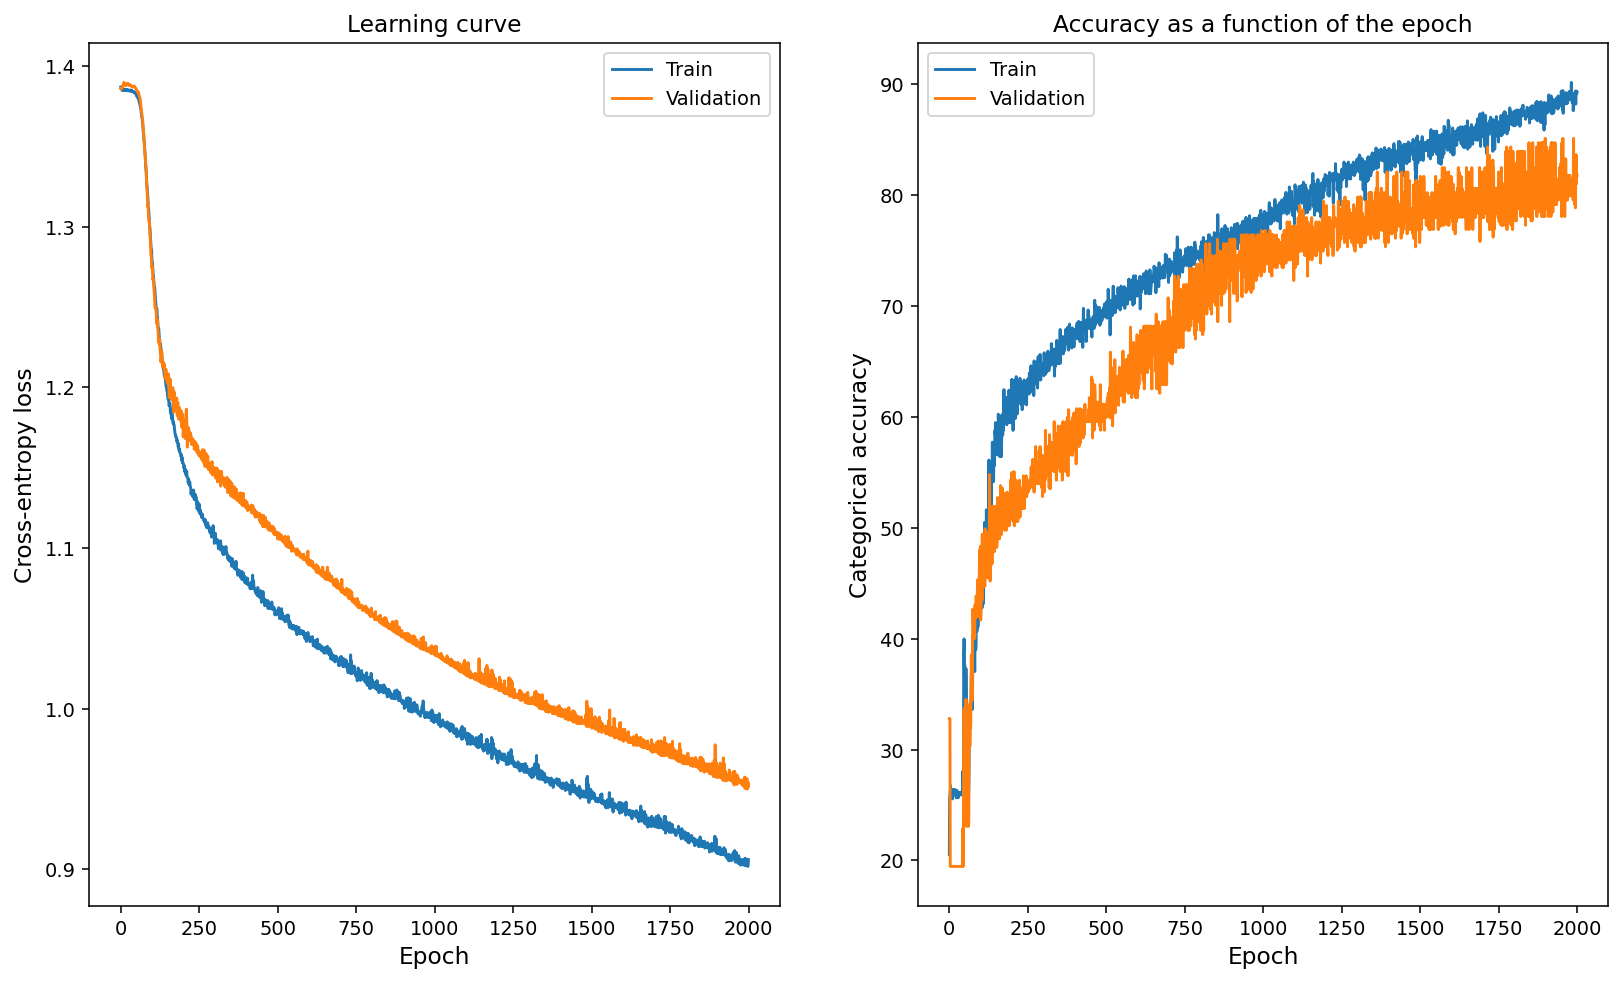

In [12]:
# Plot the learning curves

fig = plt.figure(figsize=(14, 8))

fig.add_subplot(121)
plt.plot(history['training_loss'], label='Train')
plt.plot(history['validation_loss'], label='Validation')
plt.xlabel("Epoch", size=12)
plt.ylabel("Cross-entropy loss", size=12)
plt.title("Learning curve")
plt.legend()

fig.add_subplot(122)
plt.plot(history['training_accuracy'], label='Train')
plt.plot(history['validation_accuracy'], label='Validation')
plt.xlabel("Epoch", size=12)
plt.ylabel("Categorical accuracy", size=12)
plt.title("Accuracy as a function of the epoch")
plt.legend()

plt.show()

Initially, the cross-entropy loss is rapidly decreasing and both accuracies are rapidly increasing. At approximately 200 epochs, both loss curves start decreaseasing at a slower rate than before, and both accuracy curves start increasing at a slower rate than before. The rate of change generally keeps decreasing throughout the training of the model.

After 2000 epochs, the cross-entropy loss curve has not begun to plateau, implying that more iterations are needed in order for the training to converge. However, the accuracy has began to plateau. The validation accuracy is stabilising while the training accuracy continues to increase. This suggests that there is some overfitting occuring as the model is not able to improve its ability to predict the validation data, but is still able to improve its predictions on the training data.

In [13]:
# get model predictions on test data
preds = model(torch.tensor(images_test, dtype=torch.float32).unsqueeze(1)).detach().numpy()
class_preds = np.argmax(preds, axis = 1)

# compute and display accuracies
test_accuracy = np.mean([class_preds == classes_test]) * 100
print(f"The accuracy of the CNN on the test data is {test_accuracy}%")
print(f"The accuracy of the CNN on the validation data is {np.median(history['validation_accuracy'][-10:])}%")
print(f"The accuracy of the CNN on the training data is {np.median(history['training_accuracy'][-10:])}%")

The accuracy of the CNN on the test data is 87.5%
The accuracy of the CNN on the validation data is 81.80147058823529%
The accuracy of the CNN on the training data is 88.85761335784314%


For the test data, the accuracy of our CNN model is 87.5%, which is less than 2% lower than the accuracy of our CNN model on the training data. This suggests that the model does not overfit, and has a high generalising power. This may not be entirely true due to the fact that the sample size of the test data is very small in comparison to the training data, and so the reliability of our conclusions are reduced.



---



<a name="task-12"></a>

## (1.2) [(index)](#index-task-12)

In [14]:
# Set seed for reproducibility
np.random.seed(0)

# Define indices for the split
indices = np.arange(len(images_train))
train_indices = np.random.choice(indices, size=int(0.75*len(indices)), replace=False)
val_indices = np.setdiff1d(indices, train_indices, assume_unique=True)

# Split the datasets
images_train_split = images_train[train_indices]
classes_train_split = classes_train[train_indices]
embeddings_train_split = embeddings_train[train_indices]

images_val_split = images_train[val_indices]
classes_val_split = classes_train[val_indices]
embeddings_val_split = embeddings_train[val_indices]

We add L2 regularisation to both 2D convolution layers. We do this by changing the get_model function and training_loop functions from task 1.1.

In [15]:
def get_model_reg(x_train, n_filters1, n_filters2, k1, k2, pool_size, stride_pool, classes, l2=False, l2_reg=1e-3):
    """
    CNN model in PyTorch:
    - Layers are Conv2d(+ReLU), MaxPool2d, Conv2d(+ReLU), Flatten and Linear(+Softmax).
    - It features an Adam optimizer and CrossEntropyLoss criterion.
    - Conv2d and Linear layers have regularized weights according to l2_reg.

    Parameters:
    x_train: Training data
    n_filters1: Number of filters to be used in the first convolutional layer
    n_filters2: Number of filters to be used in the second convolutional layer
    k: Tuple specifying the kernel size in the convolutional layers, e.g., (5, 5)
    pool_size: Tuple specifying the MaxPool2d window size, e.g., (2, 2)
    stride_pool: Stride of the MaxPool2d sliding window
    classes: List containing the output classes
    l2_reg: Positive float corresponding to the regularization coefficient of Conv2d and Linear

    Returns:
    model_reg, criterion_reg, and optimizer_reg.
    """

    l_out_conv1 = np.array(x_train.shape[2:]) - np.array(k1) + 1 
    l_out_pool = (l_out_conv1 - np.array(pool_size)) // stride_pool + 1  
    l_out_conv2 = l_out_pool - np.array(k2) + 1 
    l_in_linear = n_filters2 * l_out_conv2[0] * l_out_conv2[1]  

    model_reg = Sequential(
        Conv2d(1, n_filters1, k1),
        ReLU(),
        MaxPool2d(pool_size, stride=stride_pool),
        Conv2d(n_filters1, n_filters2, k2),
        ReLU(),
        Flatten(),
        Linear(l_in_linear, len(classes)),
        Softmax(dim=1),
    )
    
    # L2 regularisation
    if l2:
        for layer in model_reg.children():
            if isinstance(layer, Conv2d):
                layer.weight_regularizer = Parameter(np.sqrt(l2_reg) * torch.ones_like(layer.weight))
                
    criterion_reg = CrossEntropyLoss()
    optimiser_reg = torch.optim.Adam(model_reg.parameters())

    return model_reg, criterion_reg, optimiser_reg

In [16]:
# set seed for reproducability
torch.manual_seed(48)

# set variables required in question
n_filters1 = 4
n_filters2 = 8
k1 = 5
k2 = 5
pool_size = (2,2)
stride_pool = 2

# obtain model
model_reg, criterion_reg, optimiser_reg = get_model_reg(images_train_split, n_filters1, n_filters2, k1, k2, pool_size, stride_pool, classes, l2 = True, l2_reg = 1e-3)

In [17]:
# Numpy arrays to PyTorch tensors
x_train_tensor = torch.tensor(images_train_split, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(classes_train_split)
x_val_tensor = torch.tensor(images_val_split, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(classes_val_split)

# Creating training and validation datasets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor.squeeze())
val_dataset = TensorDataset(x_val_tensor, y_val_tensor.squeeze())

# Creating corresponding DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

In [18]:
class EarlyStopping:
    """
    EarlyStopping class.

    Attributes:
    max_patience: Amount of epochs with no improvement after which training is stopped.
    patience: Stores the number of epochs with no improvement.
    best_valid_loss: Stores the current value of the best (minimum) validation loss.
    early_stop: True if training needs to be stopped due to the early stopping condition being met.

    Methods:
    step(val_loss):
        Checks current state after an epoch and updates best_loss, patience and early_stop accordingly.
    """

    def __init__(self, max_patience=5):
        self.max_patience = max_patience
        self.patience = 0
        self.best_valid_loss = float('inf') 
        self.early_stop = False

    def step(self, val_loss):
        if val_loss < self.best_valid_loss:  
            self.best_valid_loss = val_loss  
            self.patience = 0  
        else:
            self.patience += 1
            if self.patience >= self.max_patience:
                self.early_stop = True

In [19]:
def training_loop_reg(train_loader, val_loader, max_num_epochs=2000, max_patience=150, l2 = False):
    """
    Training loop with early stopping to monitor the validation accuracy.

    Parameters:
    train_loader: Training DataLoader
    val_loader: Validation DataLoader
    max_num_epochs: Maximum number of epochs
    max_patience: max_patience attribute of the EarlyStopping class

    Returns:
    model_reg, criterion_reg and optimiser_reg.

    """

    history_reg = {'training_loss': [], 'validation_loss': [], 'training_accuracy': [], 'validation_accuracy': []}
    early_stopping = EarlyStopping(max_patience=max_patience)

    for epoch in range(max_num_epochs):

        tr_loss = 0.0
        tr_accuracy = 0
        val_loss = 0.0
        val_accuracy = 0

        # Training
        model_reg.train()
        for inputs, labels in train_loader:
            optimiser_reg.zero_grad() # Setting gradients to zero
            outputs = model_reg(inputs)
            loss = criterion_reg(outputs, labels)

            # apply L2 regularisation
            if l2:
                for layer in model_reg.children():
                    if isinstance(layer, Conv2d): # convolution layers
                        l2_norm = torch.norm(layer.weight * layer.weight_regularizer, p=2) ** 2
                        loss += l2_norm
                        
            tr_loss += loss.item()               
            tr_accuracy += (torch.max(outputs, 1)[1] == labels).sum().item() / (len(train_loader) * labels.size(0)) 
            loss.backward() # Computes gradients of the loss
            optimiser_reg.step() # Optimisation step (parameters are updated)

        history_reg['training_loss'].append(tr_loss/len(train_loader))
        history_reg['training_accuracy'].append(100*tr_accuracy)

        # Validation
        model_reg.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model_reg(inputs)
                loss = criterion_reg(outputs, labels) 
                
                if l2:
                    for layer in model_reg.children():
                        if isinstance(layer, Conv2d): # convolution layers
                            l2_norm = torch.norm(layer.weight * layer.weight_regularizer, p=2) ** 2
                            loss += l2_norm
                            
                val_loss += loss.item()
                val_accuracy += (torch.max(outputs, 1)[1] == labels).sum().item() / (len(val_loader) * labels.size(0)) 

        history_reg['validation_loss'].append(val_loss/len(val_loader))
        history_reg['validation_accuracy'].append(100*val_accuracy)
        
        # Check for early stopping
        early_stopping.step(val_loss / len(val_loader))
        if early_stopping.early_stop:
            break 

    return history_reg

In [20]:
# set variables required in question

n_filters1 = 4
n_filters2 = 8
k1 = 5
k2 = 5
pool_size = (2,2)
stride_pool = 2

max_num_epochs = 2000
max_patience = 150 

In [21]:
penalties = [0.001, 0.01, 0.1, 1, 10]
optimum_penalty = 0
optimum_accuracy = 0

for penalty in penalties:
    # set seed for reproducability
    torch.manual_seed(48)
    
    model_reg, criterion_reg, optimiser_reg = get_model_reg(images_train_split, n_filters1, n_filters2, k1, k2, pool_size, stride_pool, classes, l2 = True, l2_reg = penalty)
    history_reg = training_loop_reg(train_loader, val_loader, max_num_epochs, max_patience, l2 = True)
    
    if np.median(history_reg['validation_accuracy'][-10:]) > optimum_accuracy:
        optimum_accuracy = np.median(history_reg['validation_accuracy'][-10:])
        optimum_penalty = penalty

print(f"Best penalty: {optimum_penalty}")

Best penalty: 0.001


In [22]:
# set seed for reproducability
torch.manual_seed(48)

model_reg, criterion_reg, optimiser_reg = get_model_reg(images_train_split, n_filters1, n_filters2, k1, k2, pool_size, stride_pool, classes, l2 = True, l2_reg = optimum_penalty)
history_reg = training_loop_reg(train_loader, val_loader, max_num_epochs, max_patience, l2 = True)

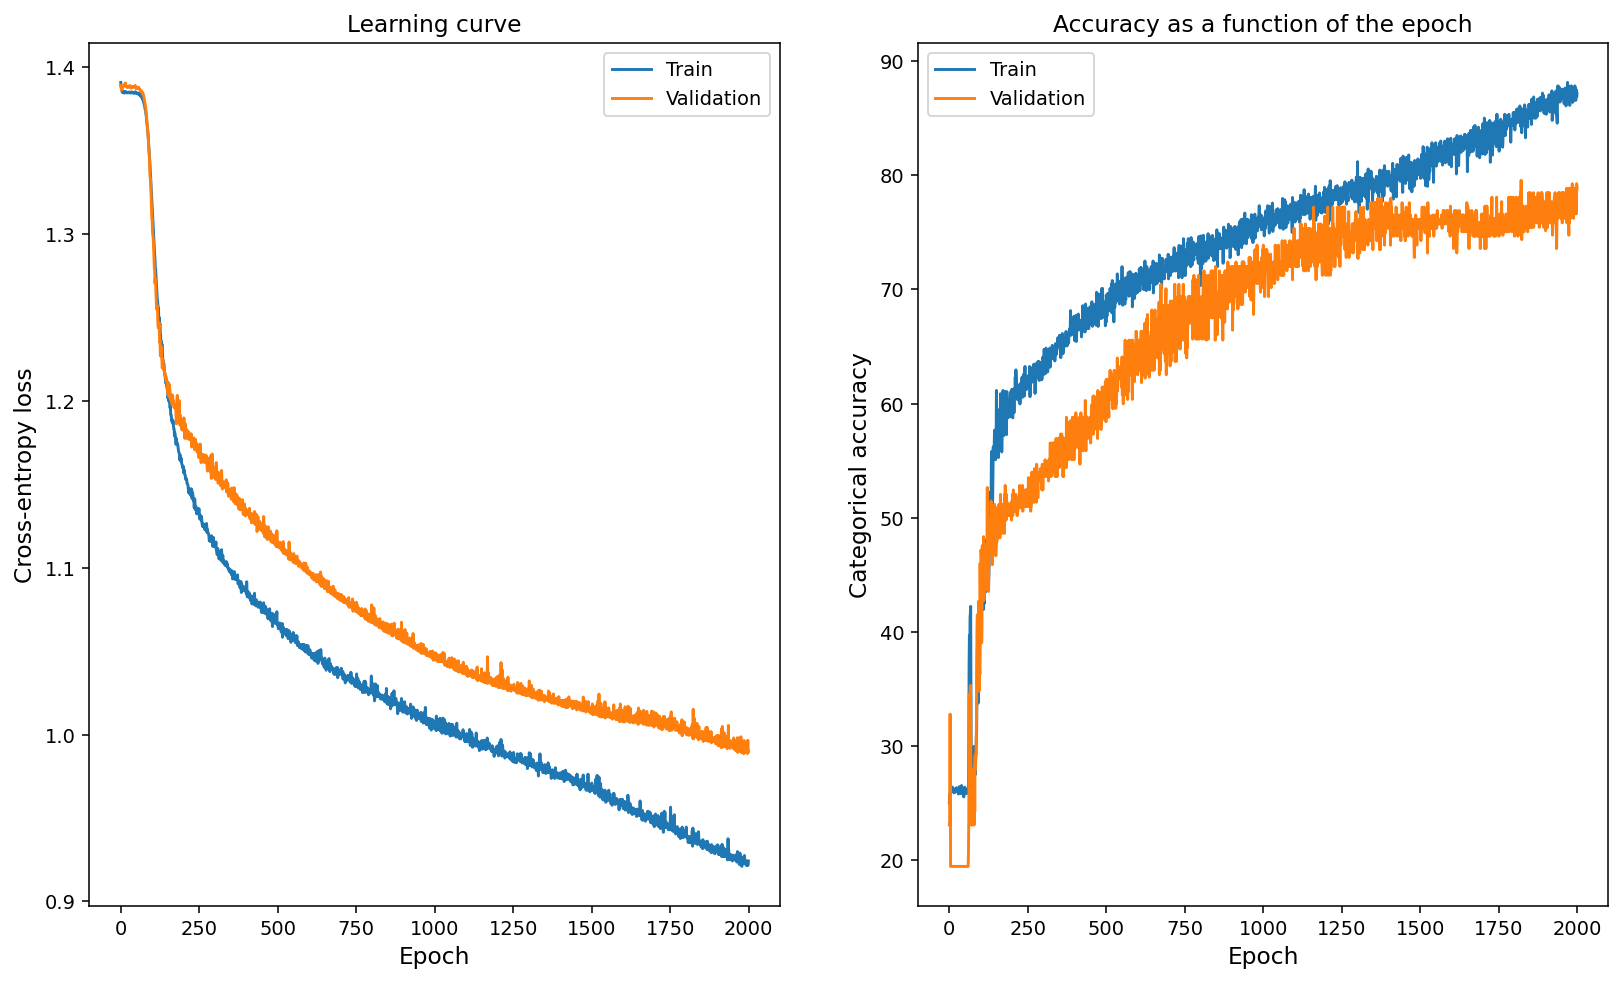

In [23]:
# Plot the learning curves

fig = plt.figure(figsize=(14, 8))

fig.add_subplot(121)
plt.plot(history_reg['training_loss'], label='Train')
plt.plot(history_reg['validation_loss'], label='Validation')
plt.xlabel("Epoch", size=12)
plt.ylabel("Cross-entropy loss", size=12)
plt.title("Learning curve")
plt.legend()

fig.add_subplot(122)
plt.plot(history_reg['training_accuracy'], label='Train')
plt.plot(history_reg['validation_accuracy'], label='Validation')
plt.xlabel("Epoch", size=12)
plt.ylabel("Categorical accuracy", size=12)
plt.title("Accuracy as a function of the epoch")
plt.legend()

plt.show()

In [24]:
# get model predictions on test data 
preds = model_reg(torch.tensor(images_test, dtype=torch.float32).unsqueeze(1)).detach().numpy()
class_preds = np.argmax(preds, axis = 1)

# compute and display accuracies
test_accuracy_reg = np.mean([class_preds == classes_test]) * 100
print(f"The accuracy of the regularised CNN on the test data is {test_accuracy_reg}%")
print(f"The accuracy of the regularised CNN on the validation data is {np.median(history_reg['validation_accuracy'][-10:])}%")
print(f"The accuracy of the regularised CNN on the training data is {np.median(history_reg['training_accuracy'][-10:])}%")

The accuracy of the regularised CNN on the test data is 90.625%
The accuracy of the regularised CNN on the validation data is 78.86029411764706%
The accuracy of the regularised CNN on the training data is 87.34106924019608%


In [25]:
accuracies = [
    ["Original", "87.5%", "81.8%", "88.9%"],
    ["Regularised", "90.6%", "78.9%", "87.3%"]
]

head = ["Model", "Test Accuracy", "Validation Accuracy", "Training Accuracy"]

print(tabulate(accuracies, headers=head, tablefmt="grid"))

+-------------+-----------------+-----------------------+---------------------+
| Model       | Test Accuracy   | Validation Accuracy   | Training Accuracy   |
+=============+=================+=======================+=====================+
| Original    | 87.5%           | 81.8%                 | 88.9%               |
+-------------+-----------------+-----------------------+---------------------+
| Regularised | 90.6%           | 78.9%                 | 87.3%               |
+-------------+-----------------+-----------------------+---------------------+


We find that for our regularised CNN model, although the accuracy on the training data is slightly lower, the accuracy on the test data is 90.6%, compared to 87.5% for the model from task 1.1. This suggests the regularised model is slightly better at predicting unseen data compared to the model without L2 regularisation, implying that adding L2 regularisation is an improvement in this aspect. By penalising larger weights, the risk of overfitting is lower for this model than for the original model from task 1.1.



---



<a name="task-13"></a>

## (1.3) [(index)](#index-task-12)

We now create an imbalanced training set by randomly dropping half of the data points in class 3 (M5V) from the original training set. We then split the resulting dataset into 75% for actual training and 25% for validation. We re-train the CNN from Task 1.1 on this imbalanced training set, plotting training and validation accuracies during training.

In [26]:
# set seed for reproducability
np.random.seed(0)

# indices of class 3 
index_3 = np.where(classes_train == 3)[0]

# randomly choose half of the indices
removed_index = np.random.choice(index_3, len(index_3) // 2, replace=False)

# delete chosen indices
images_imbalanced = np.delete(images_train, removed_index, axis=0)
classes_imbalanced = np.delete(classes_train, removed_index, axis=0)

# set seed for reproducability
np.random.seed(0)

# split imbalanced data
split_rate = 0.75
total_samples = images_imbalanced.shape[0]
train_indices = np.random.choice(total_samples, size=int(split_rate * total_samples), replace=False)
val_indices = np.setdiff1d(np.arange(total_samples), train_indices)

imbalanced_images_train, imbalanced_images_val = images_imbalanced[train_indices], images_imbalanced[val_indices]
imbalanced_classes_train, imbalanced_classes_val = classes_imbalanced[train_indices], classes_imbalanced[val_indices]

In [27]:
# Run your function to get the model and print it

# set seed for reproducability
torch.manual_seed(48)

n_filters1 = 4
n_filters2 = 8
k1 = 5
k2 = 5
pool_size = (2,2)
stride_pool = 2
l2_reg = 1e-3

model, criterion, optimiser = get_model(imbalanced_images_train, n_filters1, n_filters2, k1, k2, pool_size, stride_pool, classes, l2_reg) 

In [28]:
# Numpy arrays to PyTorch tensors
x_train_tensor = torch.tensor(imbalanced_images_train, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(imbalanced_classes_train)
x_val_tensor = torch.tensor(imbalanced_images_val, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(imbalanced_classes_val)

# Creating training and validation datasets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor.squeeze())
val_dataset = TensorDataset(x_val_tensor, y_val_tensor.squeeze())

# Creating corresponding DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

In [29]:
# Calling the training loop

# set seed for reproducability
torch.manual_seed(48)

max_num_epochs = 2000
max_patience = 150 

history = training_loop(train_loader, val_loader, max_num_epochs, max_patience)

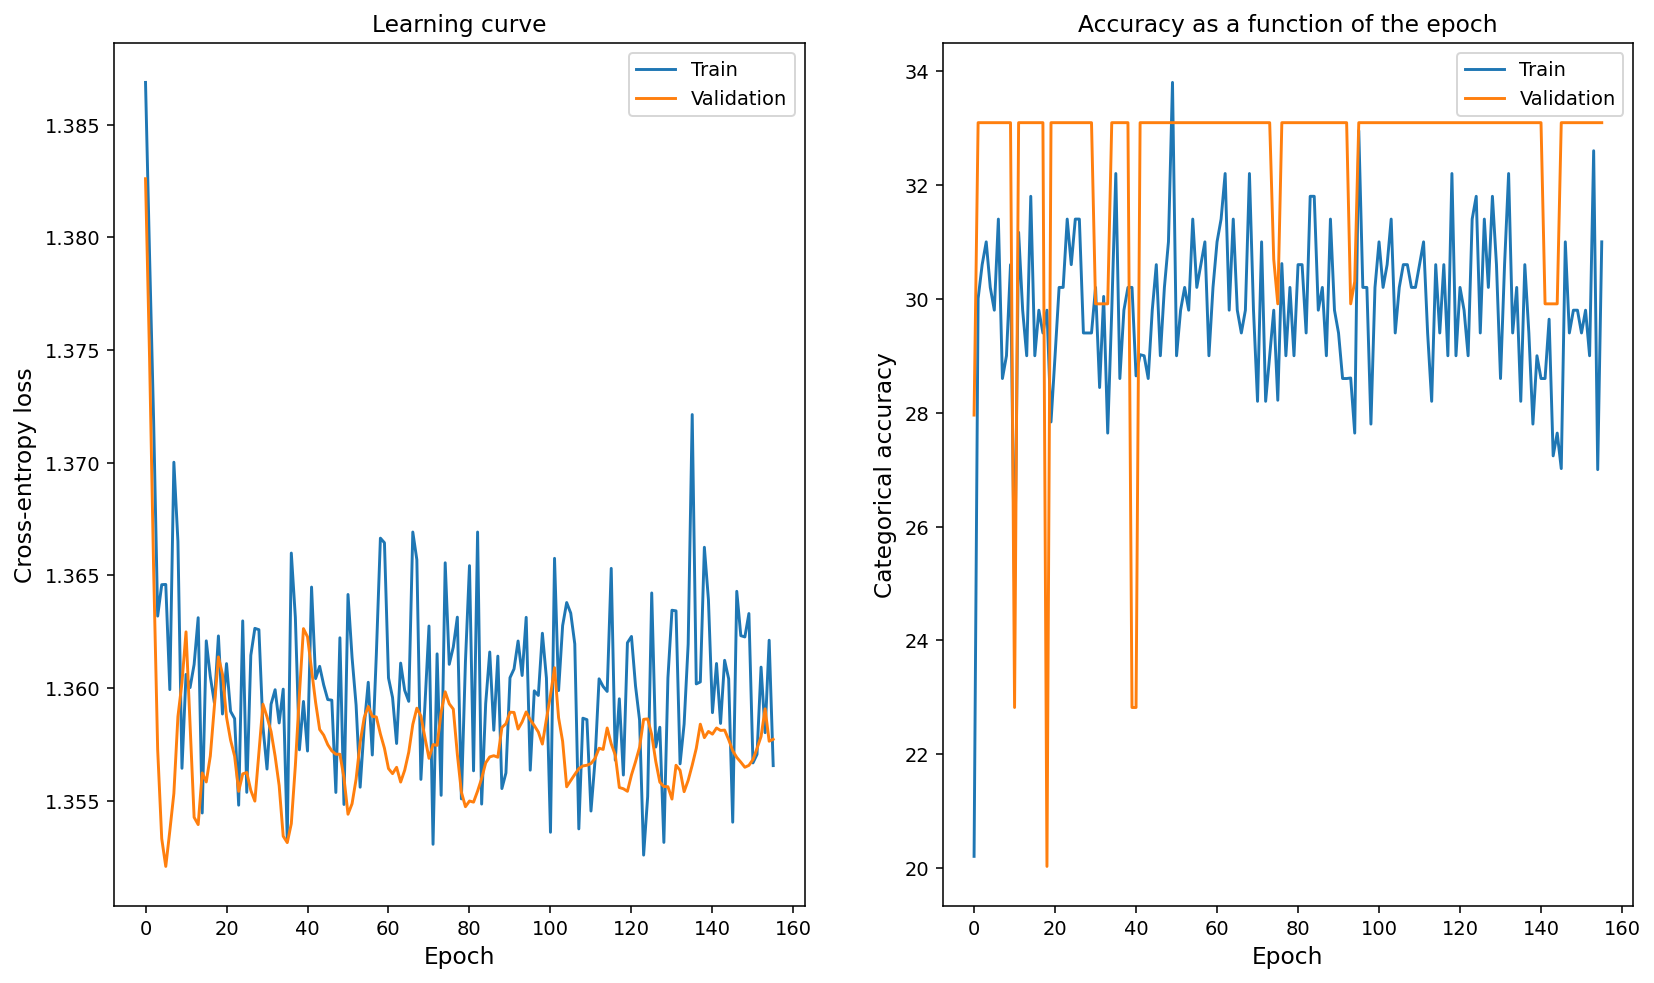

In [30]:
# Plot the learning curves

fig = plt.figure(figsize=(14, 8))

fig.add_subplot(121)
plt.plot(history['training_loss'], label='Train')
plt.plot(history['validation_loss'], label='Validation')
plt.xlabel("Epoch", size=12)
plt.ylabel("Cross-entropy loss", size=12)
plt.title("Learning curve")
plt.legend()

fig.add_subplot(122)
plt.plot(history['training_accuracy'], label='Train')
plt.plot(history['validation_accuracy'], label='Validation')
plt.xlabel("Epoch", size=12)
plt.ylabel("Categorical accuracy", size=12)
plt.title("Accuracy as a function of the epoch")
plt.legend()

plt.show()

In [31]:
# get model predictions on test data
preds = model(torch.tensor(images_test, dtype=torch.float32).unsqueeze(1)).detach().numpy()
class_preds = np.argmax(preds, axis = 1)

# compute and display accuracies
test_accuracy_imbalanced = np.mean([class_preds == classes_test]) * 100
print(f"The accuracy of the imbalanced CNN on the test data is {test_accuracy_imbalanced}%")
print(f"The accuracy of the imbalanced CNN on the validation data is {np.median(history['validation_accuracy'][-10:])}%")
print(f"The accuracy of the imbalanced CNN on the training data is {np.median(history['training_accuracy'][-10:])}%")

The accuracy of the imbalanced CNN on the test data is 25.0%
The accuracy of the imbalanced CNN on the validation data is 33.09151785714286%
The accuracy of the imbalanced CNN on the training data is 29.79910714285714%


Evidently, working with an imbalanced data set is a large disadvantage. When we re-train the CNN model from task 1.1 on this imbalanced training set, we get early stopping. This is due to the fact that our model does not improve within the set patience. This results in minimal accuracy for the test and training data. 

In [32]:
# Reweighted

We now reweight the classes in attempt to re-balance the data. For our reweighting strategy, we use as our class weights: [1,1,1,2]. This makes sense inuitively as we have deleted half of the data in class 3, and so we attempt to re-balance the data by giving the minority class double the weight of the other three classes, with the aim being to recreate the balance of our original data.

In [33]:
def get_model_reweighted(x_train, n_filters1, n_filters2, k1, k2, pool_size, stride_pool, classes, l2_reg=1e-3):
    """
    CNN model in PyTorch:
    - Layers are Conv2d(+ReLU), MaxPool2d, Conv2d(+ReLU), Flatten and Linear(+Softmax).
    - It features an Adam optimizer and CrossEntropyLoss criterion.
    - Conv2d and Linear layers have regularized weights according to l2_reg.

    Parameters:
    x_train: Training data
    n_filters1: Number of filters to be used in the first convolutional layer
    n_filters2: Number of filters to be used in the second convolutional layer
    k: Tuple specifying the kernel size in the convolutional layers, e.g., (5, 5)
    pool_size: Tuple specifying the MaxPool2d window size, e.g., (2, 2)
    stride_pool: Stride of the MaxPool2d sliding window
    classes: List containing the output classes
    l2_reg: Positive float corresponding to the regularization coefficient of Conv2d and Linear

    Returns:
    Model, criterion, and optimizer.
    """
    
    class_weights = torch.tensor([1, 1, 1, 2], dtype=torch.float)
    
    l_out_conv1 = np.array(x_train.shape[2:]) - np.array(k1) + 1 
    l_out_pool = (l_out_conv1 - np.array(pool_size)) // stride_pool + 1  
    l_out_conv2 = l_out_pool - np.array(k2) + 1 
    l_in_linear = n_filters2 * l_out_conv2[0] * l_out_conv2[1]  

    model_reweighted = Sequential(
        Conv2d(1, n_filters1, k1),
        ReLU(),
        MaxPool2d(pool_size, stride=stride_pool),
        Conv2d(n_filters1, n_filters2, k2),
        ReLU(),
        Flatten(),
        Linear(l_in_linear, len(classes)),
        Softmax(dim=1),
    )

    criterion_reweighted = CrossEntropyLoss(weight = class_weights)
    optimiser_reweighted = torch.optim.Adam(model_reweighted.parameters())

    return model_reweighted, criterion_reweighted, optimiser_reweighted

In [34]:
# Run your function to get the model and print it

# set variables required in question
n_filters1 = 4
n_filters2 = 8
k1 = 5
k2 = 5
pool_size = (2,2)
stride_pool = 2
l2_reg = 1e-3

# set seed for reproducability
torch.manual_seed(48)

model_reweighted, criterion_reweighted, optimiser_reweighted = get_model_reweighted(imbalanced_images_train, n_filters1, n_filters2, k1, k2, pool_size, stride_pool, classes, l2_reg) 

In [35]:
# Numpy arrays to PyTorch tensors
x_train_tensor = torch.tensor(imbalanced_images_train, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(imbalanced_classes_train)
x_val_tensor = torch.tensor(imbalanced_images_val, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(imbalanced_classes_val)

# Creating training and validation datasets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor.squeeze())
val_dataset = TensorDataset(x_val_tensor, y_val_tensor.squeeze())

# Creating corresponding DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

In [36]:
class EarlyStopping:
    """
    EarlyStopping class.

    Attributes:
    max_patience: Amount of epochs with no improvement after which training is stopped.
    patience: Stores the number of epochs with no improvement.
    best_valid_loss: Stores the current value of the best (minimum) validation loss.
    early_stop: True if training needs to be stopped due to the early stopping condition being met.

    Methods:
    step(val_loss):
        Checks current state after an epoch and updates best_loss, patience and early_stop accordingly.
    """

    def __init__(self, max_patience=150):
        self.max_patience = max_patience
        self.patience = 0
        self.best_valid_loss = float('inf') 
        self.early_stop = False

    def step(self, val_loss):
        if val_loss < self.best_valid_loss:  
            self.best_valid_loss = val_loss  
            self.patience = 0  
        else:
            self.patience += 1
            if self.patience >= self.max_patience:
                self.early_stop = True

In [37]:
def training_loop_reweighted(train_loader, val_loader, max_num_epochs=2000, max_patience=150):
    """
    Training loop with early stopping to monitor the validation accuracy.

    Parameters:
    train_loader: Training DataLoader
    val_loader: Validation DataLoader
    max_num_epochs: Maximum number of epochs
    max_patience: max_patience attribute of the EarlyStopping class

    Returns:
    Model, criterion and optimiser.

    """

    history_reweighted = {'training_loss': [], 'validation_loss': [], 'training_accuracy': [], 'validation_accuracy': []}
    early_stopping = EarlyStopping(max_patience=max_patience)

    for epoch in range(max_num_epochs):

        tr_loss = 0.0
        tr_accuracy = 0
        val_loss = 0.0
        val_accuracy = 0

        # Training
        model_reweighted.train()
        for inputs, labels in train_loader:
            optimiser_reweighted.zero_grad() # Setting gradients to zero
            outputs = model_reweighted(inputs)
            loss = criterion_reweighted(outputs, labels) 
            tr_loss += loss.item()
            tr_accuracy += (torch.max(outputs, 1)[1] == labels).sum().item() / (len(train_loader) * labels.size(0))  
            loss.backward() # Computes gradients of the loss
            optimiser_reweighted.step() # Optimisation step (parameters are updated)

        history_reweighted['training_loss'].append(tr_loss/len(train_loader))
        history_reweighted['training_accuracy'].append(100*tr_accuracy)

        # Validation
        model_reweighted.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model_reweighted(inputs)
                loss = criterion_reweighted(outputs, labels)  
                val_loss += loss.item()
                val_accuracy += (torch.max(outputs, 1)[1] == labels).sum().item() / (len(val_loader) * labels.size(0)) 

        history_reweighted['validation_loss'].append(val_loss/len(val_loader))
        history_reweighted['validation_accuracy'].append(100*val_accuracy)

        # Check for early stopping
        early_stopping.step(val_loss / len(val_loader))
        if early_stopping.early_stop:
            break 

    return history_reweighted

In [38]:
# Calling the training loop

max_num_epochs = 2000
max_patience = 150 

# set seed for reproducability
torch.manual_seed(48)

history_reweighted = training_loop_reweighted(train_loader, val_loader, max_num_epochs, max_patience)

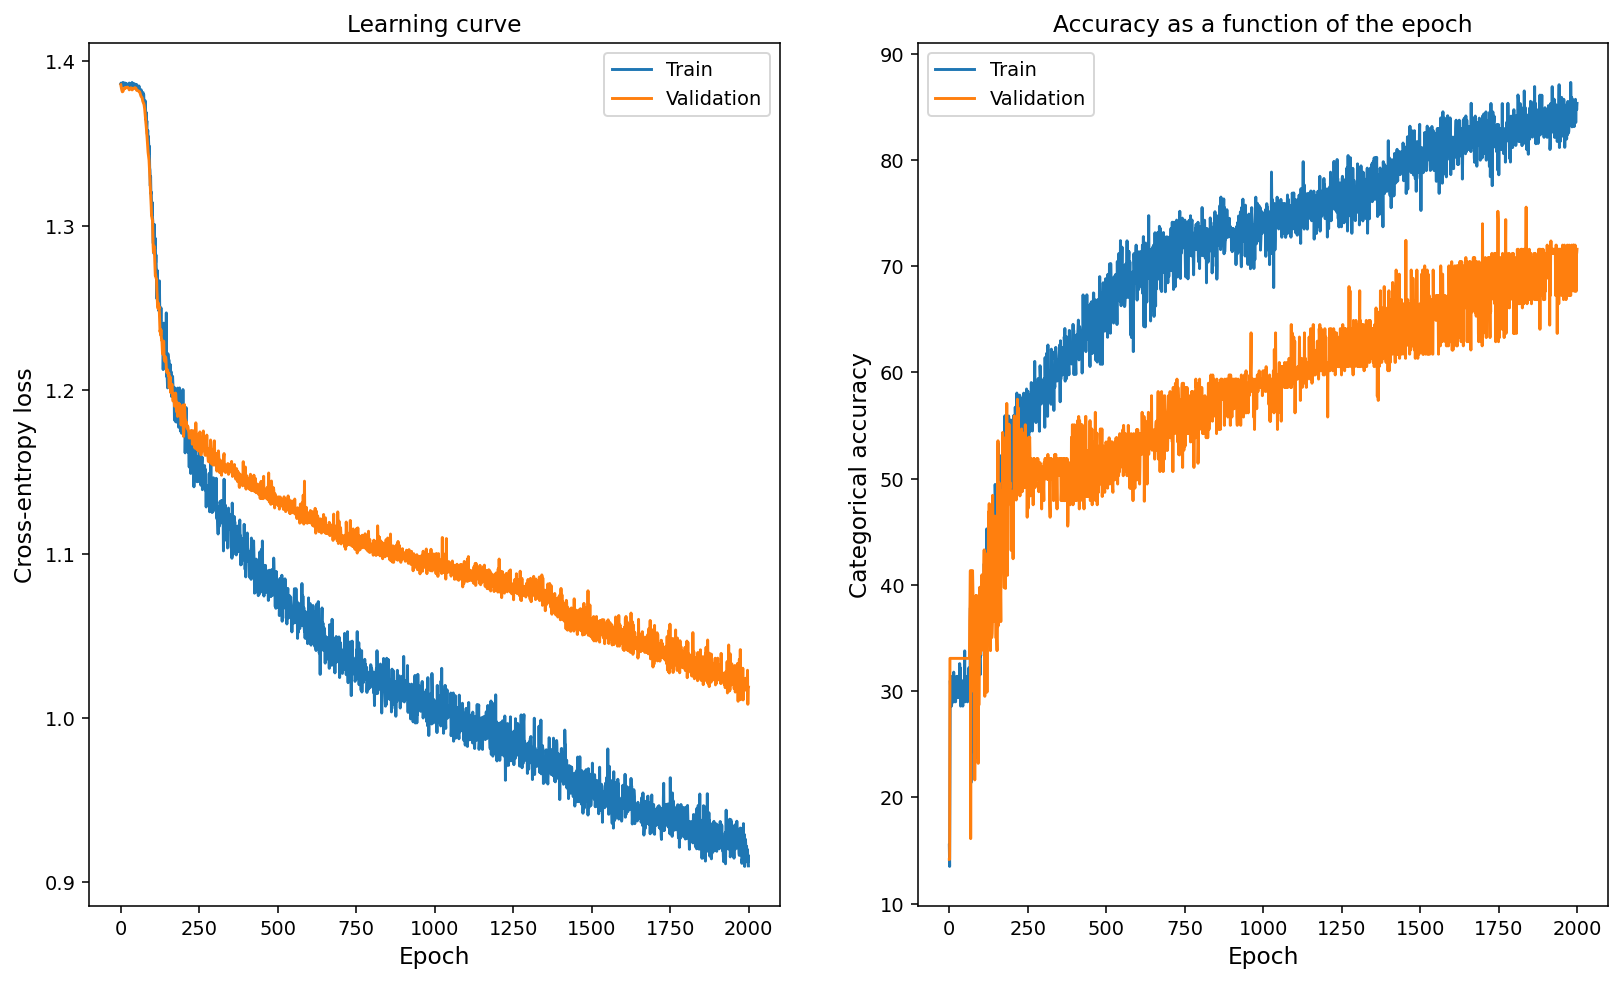

In [39]:
# Plot the learning curves

fig = plt.figure(figsize=(14, 8))

fig.add_subplot(121)
plt.plot(history_reweighted['training_loss'], label='Train')
plt.plot(history_reweighted['validation_loss'], label='Validation')
plt.xlabel("Epoch", size=12)
plt.ylabel("Cross-entropy loss", size=12)
plt.title("Learning curve")
plt.legend()

fig.add_subplot(122)
plt.plot(history_reweighted['training_accuracy'], label='Train')
plt.plot(history_reweighted['validation_accuracy'], label='Validation')
plt.xlabel("Epoch", size=12)
plt.ylabel("Categorical accuracy", size=12)
plt.title("Accuracy as a function of the epoch")
plt.legend()

plt.show()

In [40]:
# get model predictions on test data 
preds = model_reweighted(torch.tensor(images_test, dtype=torch.float32).unsqueeze(1)).detach().numpy()
class_preds = np.argmax(preds, axis = 1)

#compute and display accuracies
test_accuracy_reweighted = np.mean([class_preds == classes_test]) * 100
print(f"The accuracy of the reweighted CNN on the test data is {test_accuracy_reweighted}%")
print(f"The accuracy of the reweighted CNN on the validation data is {np.median(history_reweighted['validation_accuracy'][-10:])}%")
print(f"The accuracy of the reweighted CNN on the training data is {np.median(history_reweighted['training_accuracy'][-10:])}%")

The accuracy of the reweighted CNN on the test data is 87.5%
The accuracy of the reweighted CNN on the validation data is 71.20535714285714%
The accuracy of the reweighted CNN on the training data is 84.90978422619048%


In [41]:
# Augmented

We augment the data by duplicating the data, adding noise to one of the copies and joining it to the other copy of the class 3 data. The noise is added to each pixel drawn from the normal distribution given in the question.

In [42]:
def augment_data(x_train, y_train, c):
    # indices for class 3 samples
    indices_3 = np.where(y_train == 3)[0]

    # calculate variances for class 3
    images_3 = x_train[indices_3]
    pixel_variances = np.var(images_3, axis=0)
    
    # set seed for reproducability
    np.random.seed(0)
    
    # produce noise for each pixel
    noise = np.random.normal(0, np.sqrt(c * pixel_variances), images_3.shape)

    # add noise to images in class 3
    augmented_images = images_3 + noise
    
    # join original and augmented data
    x_train_augmented = np.concatenate([x_train, augmented_images])
    y_train_augmented = np.concatenate([y_train, 3 * np.ones(len(indices_3))])
    
    # set seed for reproducability
    np.random.seed(0)
    
    # shuffle the augmented data
    indices = np.random.choice(len(x_train_augmented), size=len(x_train_augmented), replace=False)
    x_train_augmented = x_train_augmented[indices]
    y_train_augmented = y_train_augmented[indices]

    return x_train_augmented, y_train_augmented

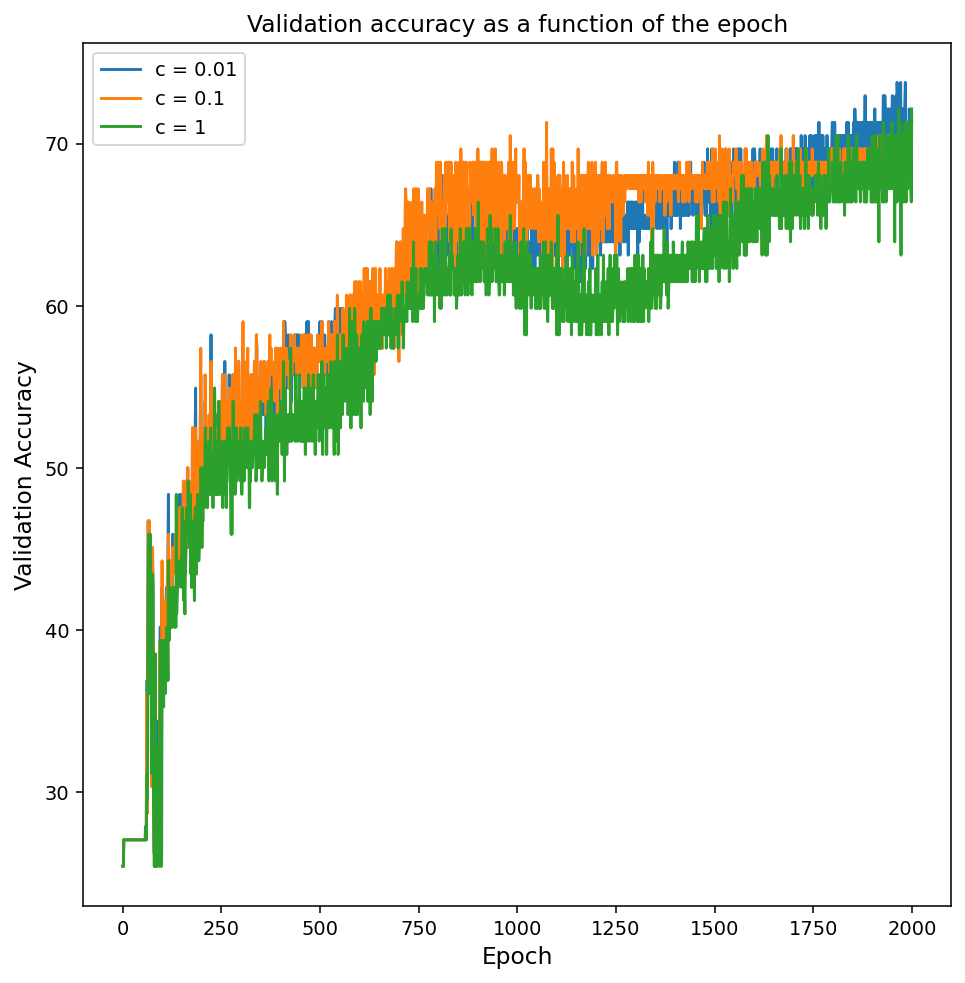

In [43]:
c_values = [0.01, 0.1, 1]

optimal_accuracy = 0

for c in c_values:
    # generate augmented data
    x_train_augmented, y_train_augmented = augment_data(imbalanced_images_train, imbalanced_classes_train, c)
    
    # set seed for reproducability
    np.random.seed(0)
    
    # split data into training and validation sets
    split_rate = 0.75
    total_samples = x_train_augmented.shape[0]
    train_indices = np.random.choice(total_samples, size = int(split_rate * total_samples), replace=False)
    val_indices = np.setdiff1d(np.arange(total_samples), train_indices)

    augmented_x_train, augmented_x_val = x_train_augmented[train_indices], x_train_augmented[val_indices]
    augmented_y_train, augmented_y_val = y_train_augmented[train_indices], y_train_augmented[val_indices]
    
    # set seed for reproducability
    torch.manual_seed(48)
    
    model, criterion, optimiser = get_model(augmented_x_train, n_filters1, n_filters2, k1, k2, pool_size, stride_pool, classes, l2_reg)  

    # Numpy arrays to PyTorch tensors
    x_train_tensor = torch.tensor(augmented_x_train, dtype=torch.float32).unsqueeze(1)
    y_train_tensor = torch.tensor(augmented_y_train,dtype=torch.long)
    x_val_tensor = torch.tensor(augmented_x_val, dtype=torch.float32).unsqueeze(1)
    y_val_tensor = torch.tensor(augmented_y_val,dtype=torch.long)

    # Creating training and validation datasets
    train_dataset = TensorDataset(x_train_tensor, y_train_tensor.squeeze())
    val_dataset = TensorDataset(x_val_tensor, y_val_tensor.squeeze())

    # Creating corresponding DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

    history = training_loop(train_loader, val_loader, max_num_epochs, max_patience)
    
    plt.plot(history['validation_accuracy'], label=f'c = {c}')

    if np.median(history['validation_accuracy'][-10:]) > optimal_accuracy:
        optimal_accuracy = np.median(history['validation_accuracy'][-10:])
        optimal_c = c
        
#plot the training curves
plt.xlabel("Epoch", size=12)
plt.ylabel("Validation Accuracy", size=12)
plt.title("Validation accuracy as a function of the epoch")
plt.legend()
plt.show()

In [44]:
print(f"Optimal c: {optimal_c}")

Optimal c: 0.01


In [45]:
# generate augmented data
x_train_augmented, y_train_augmented = augment_data(imbalanced_images_train, imbalanced_classes_train, optimal_c)

# set seed for reproducability
np.random.seed(0)

# split data into training and validation sets
split_rate = 0.75
total_samples = x_train_augmented.shape[0]
train_indices = np.random.choice(total_samples, size=int(split_rate * total_samples), replace=False)
val_indices = np.setdiff1d(np.arange(total_samples), train_indices)

augmented_x_train, augmented_x_val = x_train_augmented[train_indices], x_train_augmented[val_indices]
augmented_y_train, augmented_y_val = y_train_augmented[train_indices], y_train_augmented[val_indices]

# set seed for reproducability
torch.manual_seed(48)

model, criterion, optimiser = get_model(augmented_x_train, n_filters1, n_filters2, k1, k2, pool_size, stride_pool, classes, l2_reg)  

# Numpy arrays to PyTorch tensors
x_train_tensor = torch.tensor(augmented_x_train, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(augmented_y_train,dtype=torch.long)
x_val_tensor = torch.tensor(augmented_x_val, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(augmented_y_val,dtype=torch.long)

# Creating training and validation datasets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor.squeeze())
val_dataset = TensorDataset(x_val_tensor, y_val_tensor.squeeze())

# Creating corresponding DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

history = training_loop(train_loader, val_loader, max_num_epochs, max_patience)

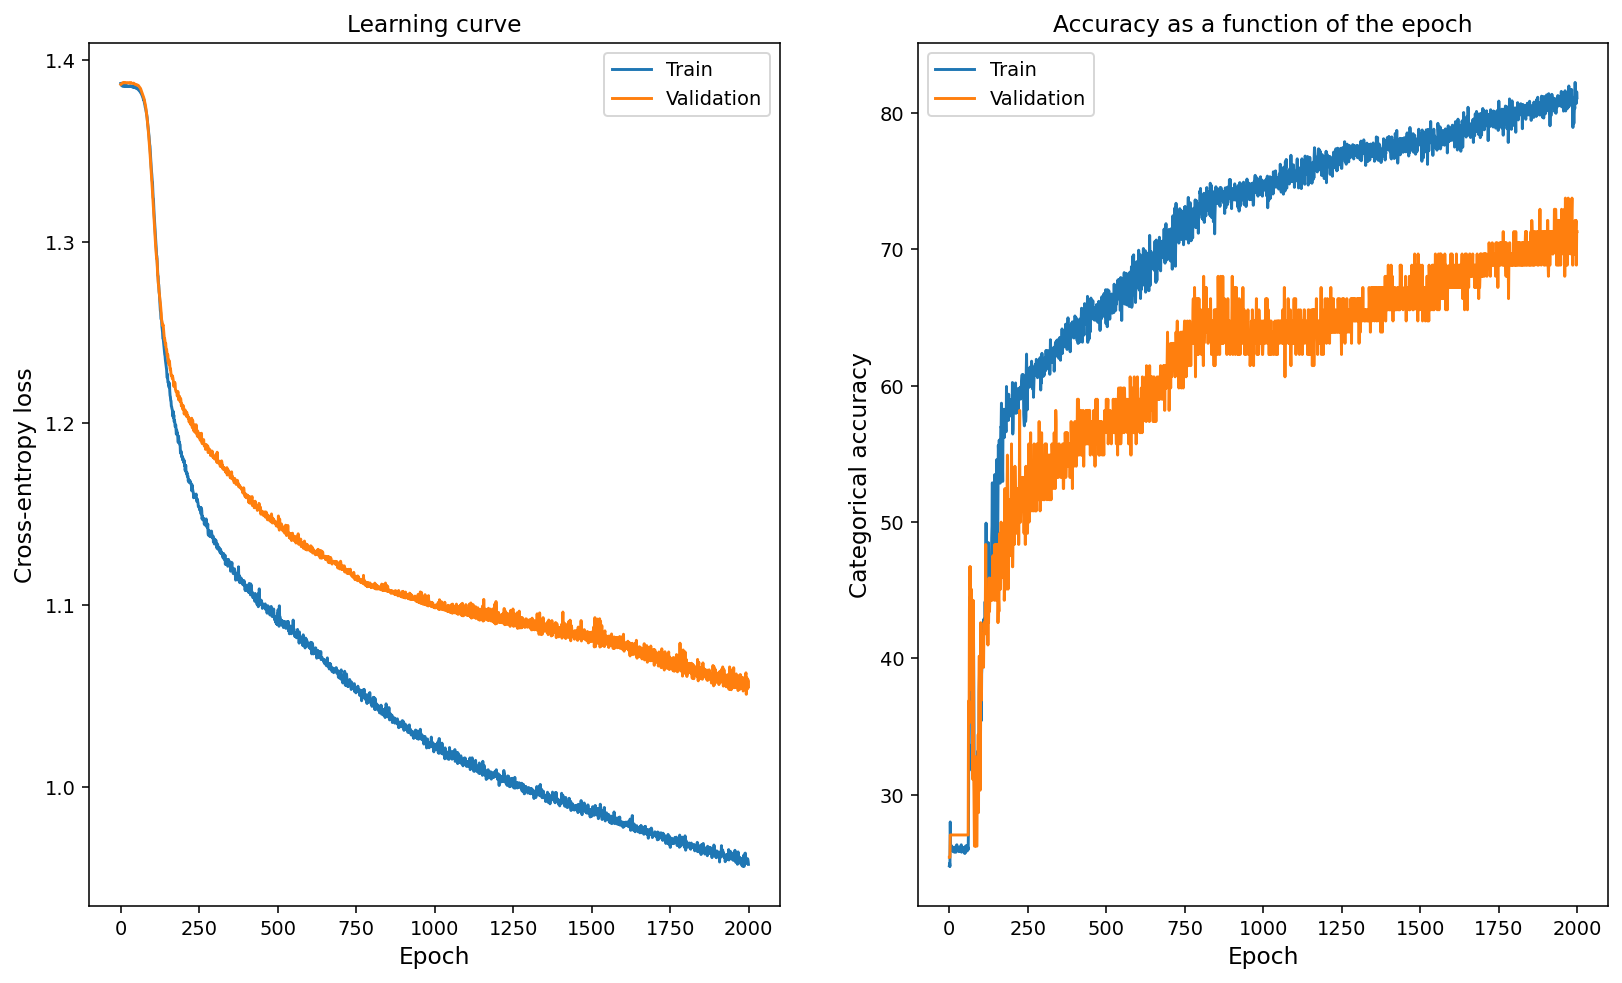

In [46]:
# Plot the learning curves

fig = plt.figure(figsize=(14, 8))

fig.add_subplot(121)
plt.plot(history['training_loss'], label='Train')
plt.plot(history['validation_loss'], label='Validation')
plt.xlabel("Epoch", size=12)
plt.ylabel("Cross-entropy loss", size=12)
plt.title("Learning curve")
plt.legend()

fig.add_subplot(122)
plt.plot(history['training_accuracy'], label='Train')
plt.plot(history['validation_accuracy'], label='Validation')
plt.xlabel("Epoch", size=12)
plt.ylabel("Categorical accuracy", size=12)
plt.title("Accuracy as a function of the epoch")
plt.legend()

plt.show()

In [47]:
# get model predictions on test data 
preds = model(torch.tensor(images_test, dtype=torch.float32).unsqueeze(1)).detach().numpy()
class_preds = np.argmax(preds, axis = 1)

# compute and display accuracies
test_accuracy_augmented = np.mean([class_preds == classes_test]) * 100
print(f"The accuracy of the CNN on the test data is {test_accuracy_augmented}%")
print(f"The accuracy of the CNN on the validation data is {np.median(history['validation_accuracy'][-10:])}%")
print(f"The accuracy of the CNN on the training data is {np.median(history['training_accuracy'][-10:])}%")

The accuracy of the CNN on the test data is 71.875%
The accuracy of the CNN on the validation data is 71.31147540983606%
The accuracy of the CNN on the training data is 81.16876911314984%


In [48]:
imbalanced_accuracies = [
    ["Reweighted", "87.5%", "71.2%", "84.9%"],
    ["Augmented", "71.9%", "71.3%", "81.2%"]
]

head = ["Model", "Test Accuracy", "Validation Accuracy", "Training Accuracy"]

print(tabulate(imbalanced_accuracies, headers=head, tablefmt="grid"))

+------------+-----------------+-----------------------+---------------------+
| Model      | Test Accuracy   | Validation Accuracy   | Training Accuracy   |
+============+=================+=======================+=====================+
| Reweighted | 87.5%           | 71.2%                 | 84.9%               |
+------------+-----------------+-----------------------+---------------------+
| Augmented  | 71.9%           | 71.3%                 | 81.2%               |
+------------+-----------------+-----------------------+---------------------+


For our reweighted CNN model, we get a training accuracy of 84.9% and a test accuracy of 87.5%. For our augmented CNN model, we get a training accuracy of 81.2% and a test accuracy of 71.9%. This suggests that the reweighted model generalises far better to unseen data. There is a large amount of overfitting occuring for the augmented model as the training accuracy is much higher than the test accuracy.

The validation accuracy for the reweighted model fluctuates a lot, especially towards the end of the training. This is due to the model overcorrecting itself when trying to optimise its parameters. The augmented model aims to re-balance the training data by duplicating the data, adding noise to one of the copies and joining it to the other copy of the class 3 data. We may end up with lower accuracies for the augmented model due to there being too much noise, even with the optimal c value being the lowest one. It is also clearly difficult for both models to generalise well since the size of class 3 has been reduced. Having more data in the minority class would give us a better idea of the trends shown by it.

We note that both of the models that we used to deal with class imbalance perform worse than the models from task 1.1 and task 1.2. This emphasises the effect of having a large sample size of balanced data on predicting unseen data.



---



<a name="task-2"></a>

# (2) Task 2: Dimensionality Reduction: PCA vs ISOMAP [(index)](#index-task-2)

<a name="task-21"></a>

## (2.1) [(index)](#index-task-21)

In [49]:
# import datasets

classes_train = np.load('star_classes_train.npy')
classes_test = np.load('star_classes_test.npy')

images_train = np.load('star_images_train.npy')
images_test = np.load('star_images_test.npy')

embeddings_train = np.load('star_embeddings_train.npy')

In [50]:
# define classes

classes = ['O5V', 'A0V', 'F5V', 'M5V']

class0 = np.where(classes_train == 0)
class1 = np.where(classes_train == 1)
class2 = np.where(classes_train == 2)
class3 = np.where(classes_train == 3)

value_to_type = {0 : 'O5V', 1 : 'A0V', 2 : 'F5V', 3 : 'M5V'}

In [51]:
def standardise(X):
    """
    Arguments:
    X: Data with samples being indexed along axis 0.

    Returns:
    Xbar: Standardised data.

    """
    mu = np.mean(X, axis=0)
    std = np.std(X, axis=0) 
    std[std==0] = 1. 
    Xbar = (X - mu) / std 

    return Xbar

In [52]:
# standardise embedding vectors

X_norm = standardise(embeddings_train)

In [53]:
# covariance matrix and pca_functions from week 8 lab

def covariance_matrix(X):
    """
    Arguments:
    X: Data with samples being indexed along axis 0.

    Returns:
    Xbar: Computes the data covariance matrix.

    """
    return np.dot(X.T, X) / len(X) 

def pca_function(X, k):
    """
    Arguments:
    X: Data with samples being indexed along axis 0.
    k: Number of principal components.

    Returns:
    X_pca: Transformed data.
    eigenvectors: First k eigenvectors of C.
    eigenvalues: First k eigenvalues of C.

    """
    # Computing the covariance matrix
    C = covariance_matrix(X)

    # Computing the eigenvalues and eigenvectors using the eigsh scipy function
    eigenvalues, eigenvectors = linalg.eigsh(C, k, which='LM', return_eigenvectors=True) 

    # Sorting the eigenvectors and eigenvalues from largest to smallest eigenvalue
    sorted_index = np.argsort(eigenvalues)[::-1] 
    eigenvalues = eigenvalues[sorted_index] 
    eigenvectors = eigenvectors[:,sorted_index] 

    # Projecting the data onto the directions of eigenvectors
    X_pca = X.dot(eigenvectors) 

    return X_pca, eigenvectors, eigenvalues

We perform PCA of the standardised embedding vectors for k = 2 principal components.

In [54]:
k = 2 # our number of principal components
X_pca, eigenvectors, eigenvalues = pca_function(X_norm, k)

# first two principal components
first_principal_component = X_pca[:, 0]
second_principal_component = X_pca[:, 1]

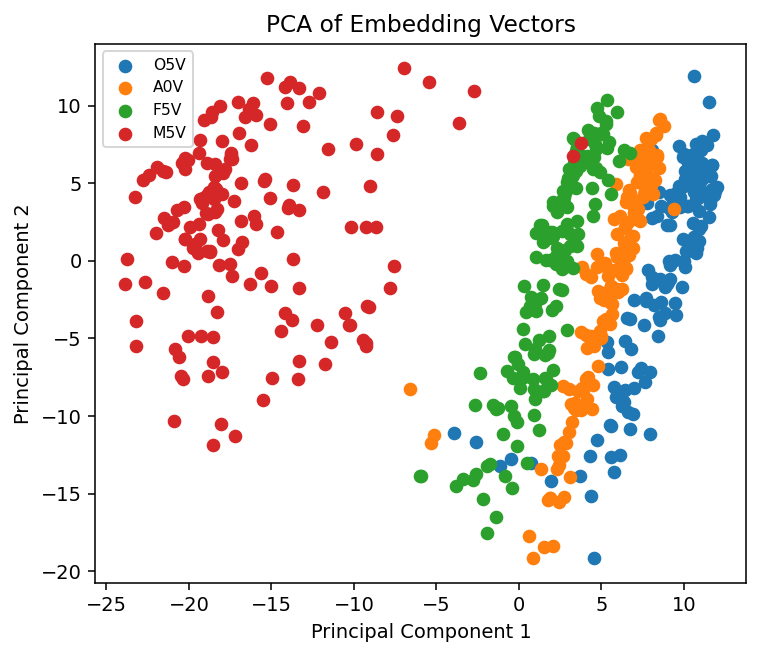

In [55]:
# Create the scatter plot
plt.figure(figsize=(6,5))

for class_i in range(len(classes)):
    # Select the embeddings belonging to the current class
    indices = np.where(classes_train == class_i)
    plt.scatter(first_principal_component[indices], second_principal_component[indices], label=classes[class_i])

plt.title('PCA of Embedding Vectors')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(fontsize=8)
plt.show()

We can see that PCA can accurately separate the stars of each type into clusters. In particular, the first principal component separates the four stellar classes clearly. There is a gap between the M5V class and the others on the plot. This could be because it is much colder than the others, seeing as the classes appear to be ordered by spectral type. Therefore, it is possible that the first principal component relates to the temperature component of the star, capturing the majority of the variance in the data. The second principal component doesn't appear to show any useful trends. We also notice that the O5V, A0V, and F5V clusters all have similar shapes, possibly indicating that there is some similarity betweeen them.

We now compute the Davies-Bouldin Index measure of clustering quality.

In [56]:
# compute centroids function from week 7 lab

def compute_centroids(k, X, labels):
    """
    Compute the centroids of the clustered points X.

    Args:
        k (int): total number of clusters.
        X (np.ndarray): data points, with shape (N, p)
        labels (np.ndarray): cluster assignments for each sample in X, with shape (N,).

    Returns:
        (np.ndarray): the centroids of the k clusters, with shape (k, p).
    """
    N, p = X.shape

    centroids = np.zeros((k, p))

    for label in range(k):
        cluster_X_l = X[labels == label]
        centroids[label] = cluster_X_l.mean(axis=0) 

    return centroids

In [57]:
def davies_bouldin_index(centroids, X, labels):
    """
    Compute the Davies-Bouldin Index.
    Args:
        centroids (np.ndarray): the centroids of the clusters.
        X (np.ndarray): data points.
        labels (np.ndarray): clusters for each sample in X.
    Returns:
        float: The Davies-Bouldin Index.
    """
    C, _ = centroids.shape
    
    # distance matrix between centroids
    M = np.linalg.norm(centroids[:, np.newaxis, :] - centroids[np.newaxis, :, :], axis=2)
    
    # compute S
    S = np.zeros(C)
    for i in range(C):
        points = X[labels == i]
        centroid = centroids[i]
        distances = np.linalg.norm(points - centroid, axis=1)
        S[i] = np.mean(distances)
    
    # compute Davies-Bouldin Index
    davies_bouldin_index = 0.0
    
    for i in range(C):
        F = (S + S[i]) / (M[i] + 1e-6) # avoid dividing by zero
        F[i] = 0 # exclude cluster itself
        davies_bouldin_index += np.max(F)
        
    # average the sum of maximum F over all clusters
    davies_bouldin_index /= C
    
    return davies_bouldin_index

In [58]:
centroids = compute_centroids(4, X_pca, classes_train)
db_index = davies_bouldin_index(centroids, X_pca, classes_train)
print('Davies-Bouldin Index:', db_index)

Davies-Bouldin Index: 2.85336970460723


In this case, the Davies-Bouldin Index evaluates how effective PCA is at separating the star types into clusters. This effectiveness is based on both the cluster dispersion and the cluster separation, where the cluster dispersion represents how far the points in a cluster are from their centroid and the cluster separation represents how far the centroids of different clusters are from one another. A lower score indicates the clusters are well-separated from each other and the data points are close together.

Our calculated value of Davies-Bouldin Index is 2.85. It is difficult to evaluate how good this is, however our PCA plot appears to separate the clusters relatively well, so we can assume that this Davies-Bouldin Index is not too bad.



---



<a name="task-22"></a>

## (2.2) [(index)](#index-task-22)

In [59]:
# we define node colours consistent with the plot above
cmap = plt.colormaps.get_cmap('tab10')
color_type = [cmap(i) for i in classes_train]

We compute the matrix D of pairwise cosine distances.

In [60]:
def cosine_distance(X):
    """
    Compute pairwise cosine distance between vectors in matrix X.

    Args:
        X (np.ndarray): Input matrix with shape (N, p), where N is the number of vectors and p is the dimensionality.
    Returns:
        np.ndarray: Pairwise cosine distance matrix with shape (N, N).
    """
    N, p = X.shape
    
    # compute numerator
    dot_products = X @ X.T
    
    # compute L2 norm
    X_norm = np.linalg.norm(X, axis=1).reshape(N, 1)
    
    # compute fraction
    cosine_similarity = dot_products / (X_norm @ X_norm.T)
    
    # compute matrix D of pairwise cosine distances
    D = 1 - cosine_similarity
    
    return D

In [61]:
cosine_dist = cosine_distance(embeddings_train)

We now compute the adjacency matrix A of the kNN graph for k = 9.

In [62]:
def weighted_knn_matrix(cosine_dist, k):
    """
    Compute the weighted k-nearest neighbours matrix from the cosine distance matrix.
    Args:
        cosine_dist (np.ndarray): Cosine distance matrix.
        k (int): Number of nearest neighbours.
    Returns:
        np.ndarray: Weighted k-nearest neighbours matrix.
    """
    # include the point itself in kNN
    k += 1

    A_unweighted = np.zeros_like(cosine_dist) # unweighted
    A_weighted = np.zeros_like(cosine_dist) # weighted

    # unweighted matrix
    for row in range(cosine_dist.shape[0]):
        index = np.argsort(cosine_dist[row])[:k]
        A_unweighted[row][index] = 1
    
    # nearest neighbour
    A_weighted[(A_unweighted + A_unweighted.T) > 0] = 1 

    # multiply by cosine distance to create the weighted matrix
    A_weighted = A_weighted * cosine_dist

    # set diagonal elements to 0
    np.fill_diagonal(A_weighted, 0)
    
    return A_weighted

In [63]:
A = weighted_knn_matrix(cosine_dist, k=9)

In [64]:
N = A.shape[0]  

# compute degrees
d = A.sum(axis=0)  

# define diagonal degree matrix
D = np.diag(d)  

# compute combinatorial Laplacian
L = D - A       

# compute square root of inverse diagonal degree matrix
D_sqrt_inv = np.diag(1/np.sqrt(d)) 

# compute symmetric normalised Laplacian
L_s = D_sqrt_inv @ L @ D_sqrt_inv

In [65]:
# compute eigen decomposition
eigenvals, eigenvecs = np.linalg.eigh(L_s)       

# sort eigenvalues and corresponding eigenvector
eigenvecs = eigenvecs.T[np.argsort(eigenvals)]   
eigenvals = np.sort(eigenvals) 

In [66]:
# get second (Fiedler) and third eigenvectors
v2 = eigenvecs[1]       
v3 = eigenvecs[2]       

# normalise coordinates
x = D_sqrt_inv @ v2      
y = D_sqrt_inv @ v3     

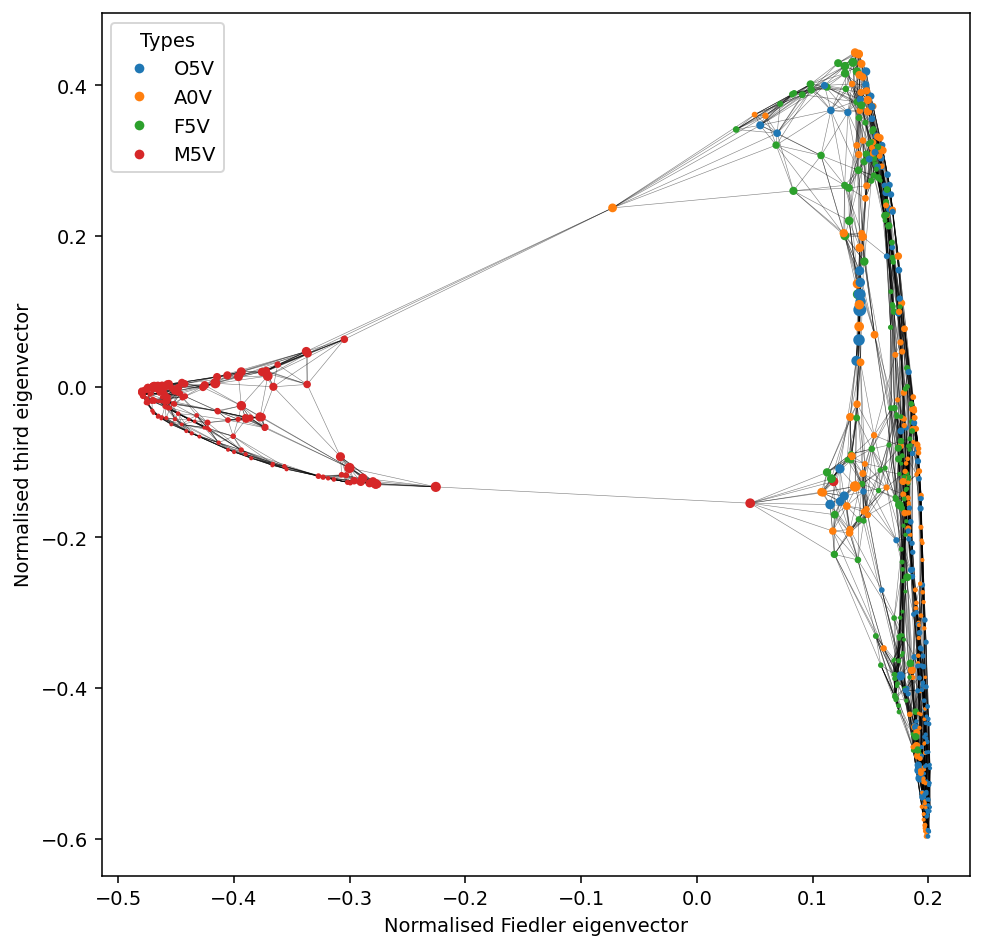

In [67]:
# plot
fig, ax = plt.subplots(1)

# plot edges
for i in range(N):
    for j in range(i+1,N):
        if A[i,j] > 0:
            ax.plot([x[i],x[j]],[y[i],y[j]], color="black", alpha=0.5, linewidth=0.3)

# plot nodes
scatter = ax.scatter(x,y,s= 200*d, c=color_type, zorder=10)

# plot legend
# create legend for node types
types_legend = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=cmap(value)) for value, label in value_to_type.items()]
plt.legend(handles=types_legend, title='Types')

# set labels
ax.set(xlabel="Normalised Fiedler eigenvector", ylabel="Normalised third eigenvector")
plt.show()

The normalised Fieldler eigenvector corresponds to the smallest non-trivial eigenvalue, and it separates the M5V stellar class from the other three classes. The normalised third eigenvector doesn't seem to be effective whatsoever at separating the stellar classes. 

We can see that the M5V stars are very isolated and it is difficult to distinguish between the other three star classes, with all three having similar cosine distances. This suggests that there may be an underlying similarity between them. Perhaps this similarity is temperature, but it is difficult to say for certain.



---



<a name="task-22"></a>

## (2.3) [(index)](#index-task-23)

In [68]:
def weighted_knn_matrix(cosine_dist, k):
    """
    Compute the weighted k-nearest neighbours matrix from the cosine distance matrix.
    Args:
        cosine_dist (np.ndarray): Cosine distance matrix.
        k (int): Number of nearest neighbours.
    Returns:
        np.ndarray: Weighted k-nearest neighbours matrix.
    """
    # include the point itself in kNN
    k += 1

    A_unweighted = np.zeros_like(cosine_dist) # unweighted
    A_weighted = np.zeros_like(cosine_dist) # weighted

    # unweighted matrix
    for row in range(cosine_dist.shape[0]):
        index = np.argsort(cosine_dist[row])[:k]
        A_unweighted[row][index] = 1
    
    # nearest neighbour
    A_weighted[(A_unweighted + A_unweighted.T) > 0] = 1 

    # multiply by cosine distance to create the weighted matrix
    A_weighted = A_weighted * cosine_dist

    # set diagonal elements to 0
    np.fill_diagonal(A_weighted, 0)
    
    return A_weighted

In [69]:
A = weighted_knn_matrix(cosine_dist, k=9)

In [70]:
# compute number of nodes
N = A.shape[0]  

## EDIT THIS CELL
d = A.sum(axis=0)   

# define diagonal degree matrix
D = np.diag(d)       

# compute combinatorial Laplacian
L = D - A 

We use the formulae provided to create gamma and the resistance distance matrix.

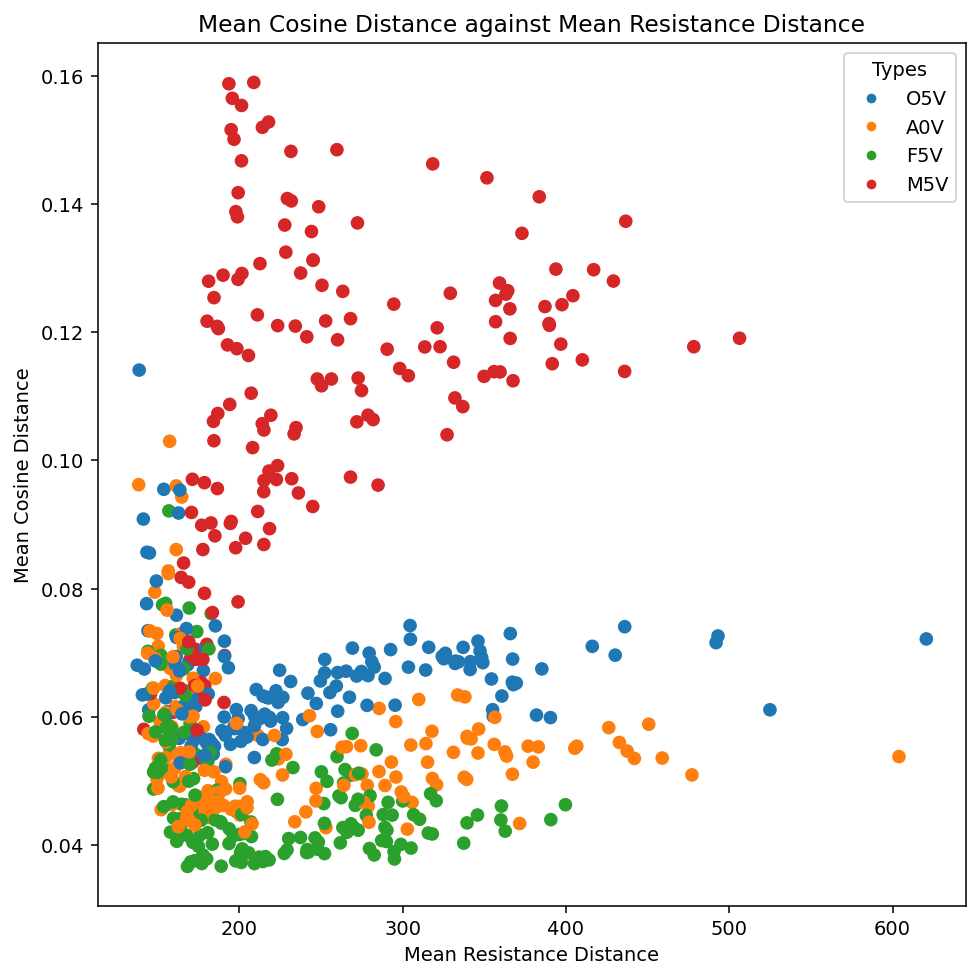

<Figure size 1120x1120 with 0 Axes>

In [71]:
# form gamma using formula given
gamma = np.linalg.pinv(L - 1/N * np.ones((N, N)))

# form resistance distance matrix using formula given
R = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        R[i,j] = gamma[i,i]+ gamma[j,j] - 2 * gamma[i,j]

# exclude the point itself
for i in range(N):
    R[i,i] = 0
    cosine_dist[i,i] = 0

resistance_mean = np.mean(R, axis = 0) * N/(N-1) # exclude the point itself
cosine_mean = np.mean(cosine_dist, axis = 0) * N/(N-1) # exclude the point itself

plt.scatter(resistance_mean, cosine_mean, c = color_type)
plt.xlabel('Mean Resistance Distance')
plt.ylabel('Mean Cosine Distance')
plt.title('Mean Cosine Distance against Mean Resistance Distance')
types_legend = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=cmap(value)) for value, label in value_to_type.items()]
plt.legend(handles=types_legend, title='Types')
plt.show()
plt.clf()

We can see in the plot above that there is a wide range of mean cosine distances and mean resistance distances for stars in all star types. In particular, the variance of the mean cosine distances for the M5V stars is larger than it is for the others.

It appaears that the star types are separated by mean cosine distance, but not mean resistance distance. This suggests that there is no obvious relationship between the mean resistance distance and the star type. 

We now find the eigenvectors of tau and visualise the embeddings in the 2D space of the top two eigenvectors of tau.

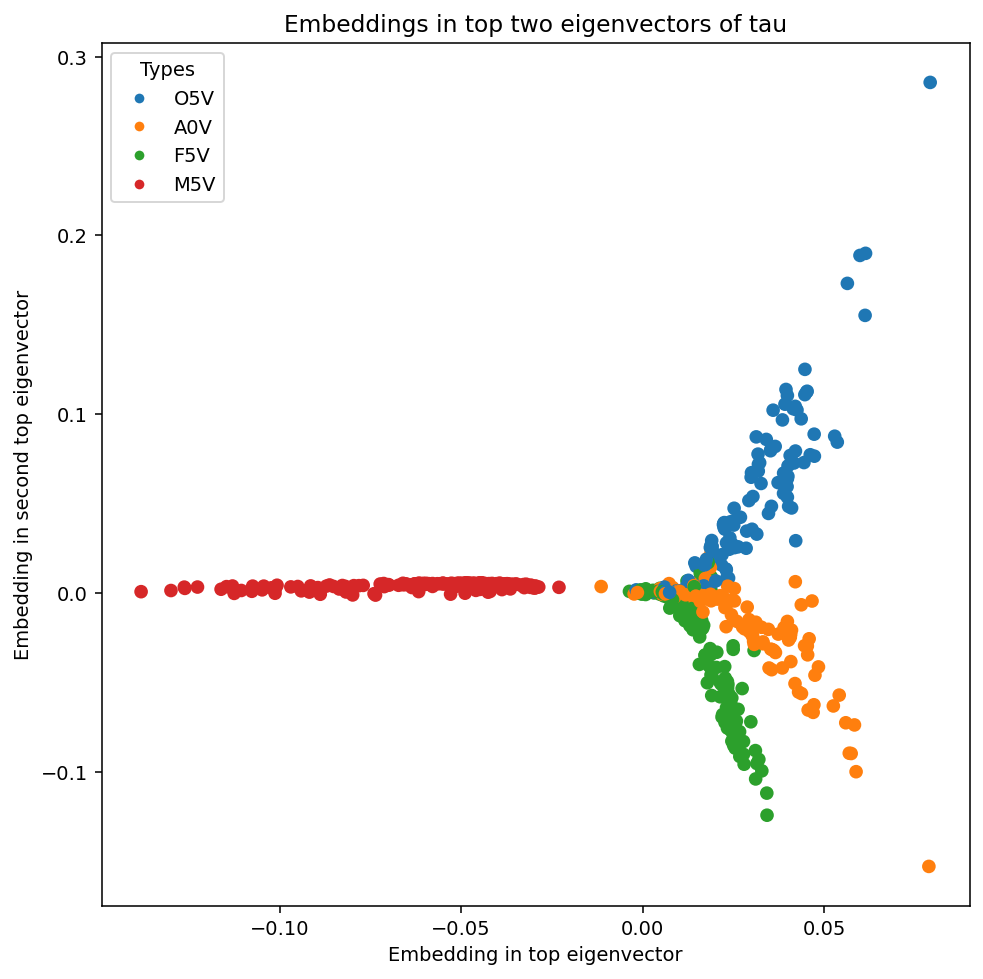

In [72]:
H = np.identity(N) - np.ones((N, N))/N

S = R ** 2

T = - H @ S @ H / 2

# compute eigen decomposition
eigenvals, eigenvecs = np.linalg.eigh(T)       

# sort eigenvalues and corresponding eigenvector
eigenvecs = eigenvecs.T[np.argsort(eigenvals)]   
eigenvals = np.sort(eigenvals)

v1 = eigenvecs[-1]        
v2 = eigenvecs[-2]        

plt.scatter(v1, v2, c=color_type, zorder =10)
plt.xlabel('Embedding in top eigenvector')
plt.ylabel('Embedding in second top eigenvector')
plt.title('Embeddings in top two eigenvectors of tau')
plt.legend(handles=types_legend, title='Types')
plt.show()

We observe that the embedding in the top eigenvector is very similar to the first principal component in the PCA plot. Once again, the M5V cluster is isolated and the other three are relatively close together. Again this suggests that there is an underlying similarity between the three star types that are close together, which may be temperature as before. This is also emphasised by the directions of these three star types in the plot compared to the M5V star type.

The embedding vector in the second top eigenvector is very different from the second principal component in the PCA plot. We now observe that the 05V stellar class is separated from the A0V and F5V stellar classes, meaning that there may be characteristic that these two classes share but the O5V star class does not.

In [74]:
centroids2 = compute_centroids(4, np.column_stack((v1,v2)), classes_train)
db_index2 = davies_bouldin_index(centroids2, np.column_stack((v1,v2)), classes_train)
print('Davies-Bouldin Index:', db_index2)

Davies-Bouldin Index: 1.9392601358995325


The Davies-Bouldin Index for this 2D representation is 1.94, which is 32% lower than that of the 2D representation from PCA in task 2.1. This implies that this 2D representation is more effective at separating the star classes into clusters than the 2D representation from PCA. This is what we would expect as we now have an additional characteristic which has a significant effect on separating the stellar classes, which PCA did not pick up. However, this does not mean that the Davies-Bouldin Index is very good, as we can see that the cluster separation between O5V, A0V, and F5V is relatively small.



---

